<a href="https://colab.research.google.com/github/fariyanalam/Projects/blob/main/PHYS152_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classification of Supersymmetric and Standard Model Particles


**Introduction and Overview:**

The Large Hadron Collider (LHC) is a particle accelerator that allows for the collision of high-energy particles at nearly the speed of light. Since its introduction, the LHC has driven significant advancements in particle physics, including the discovery of the Higgs boson, which confirmed theoretical predictions beyond the Standard Model. Supersymmetry is a proposed extention of the Standard Model, which predicts that each fundamental particle has a partner particle with a different spin.

However, distinguishing between these particles is challenging classification problem due to the complex and overlapping nature of collision data. The purpose of this project is to apply machine learning techniques to classify LHC collision events, using a binary classifier to distinguish between SM and SUSY particles and an autoencoder for feature extraction.

The dataset used for this project is the [Supersymmetry (SUSY) Dataset](https://www.kaggle.com/datasets/janus137/supersymmetry-dataset) from Kaggle, which consists of 5 million simulated collision events based on 8 TeV proton-proton collisions at the LHC.
By advancing our understanding of supersymmetry, particle physicists can continue searching for new physics beyond the Standard Model.

**Data Loading & Exploration:**

The first step is to download the data and to assign columns. The dataset is then split into features (X) and labels (y). Finally, the features are scaled to ensure consistent input ranges and visualed through histograms to observe the distributions of each feature.

100%|██████████| 762M/762M [00:29<00:00, 27.4MB/s]

Extracting files...


   label  lepton_pT  lepton_eta  lepton_phi  missing_energy_magnitude  \
0    0.0   0.707258    0.613159   -0.763354                  1.010814   
1    0.0   0.493745   -1.745581   -0.640968                  0.576161   
2    1.0   1.305413    0.283820   -1.149154                  0.507217   
3    1.0   0.809715   -0.358303   -0.497172                  0.787675   
4    0.0   0.912852    1.797455   -1.360165                  0.496723   

   missing_energy_phi   jet1_pT  jet1_eta  jet1_phi   jet2_pT  jet2_eta  \
0            1.672101  1.544314  0.342641  0.286944  0.514347 -0.008000   
1           -0.514477 -0.629788  0.585841  0.874038  0.879419 -0.221701   
2           -0.194161  1.313993  0.659832  0.619593  0.534922 -0.320298   
3            0.027419  1.201305  0.790556 -0.861923  0.740287  0.890525   
4            1.199644  0.627462  1.206452 -1.362983  0.033791  1.509121   

   jet2_phi   jet3_pT  jet3_eta  jet3_phi   jet4_pT  jet4_eta  jet4_phi  \
0  0.832800  0.646217  0.688581  1.

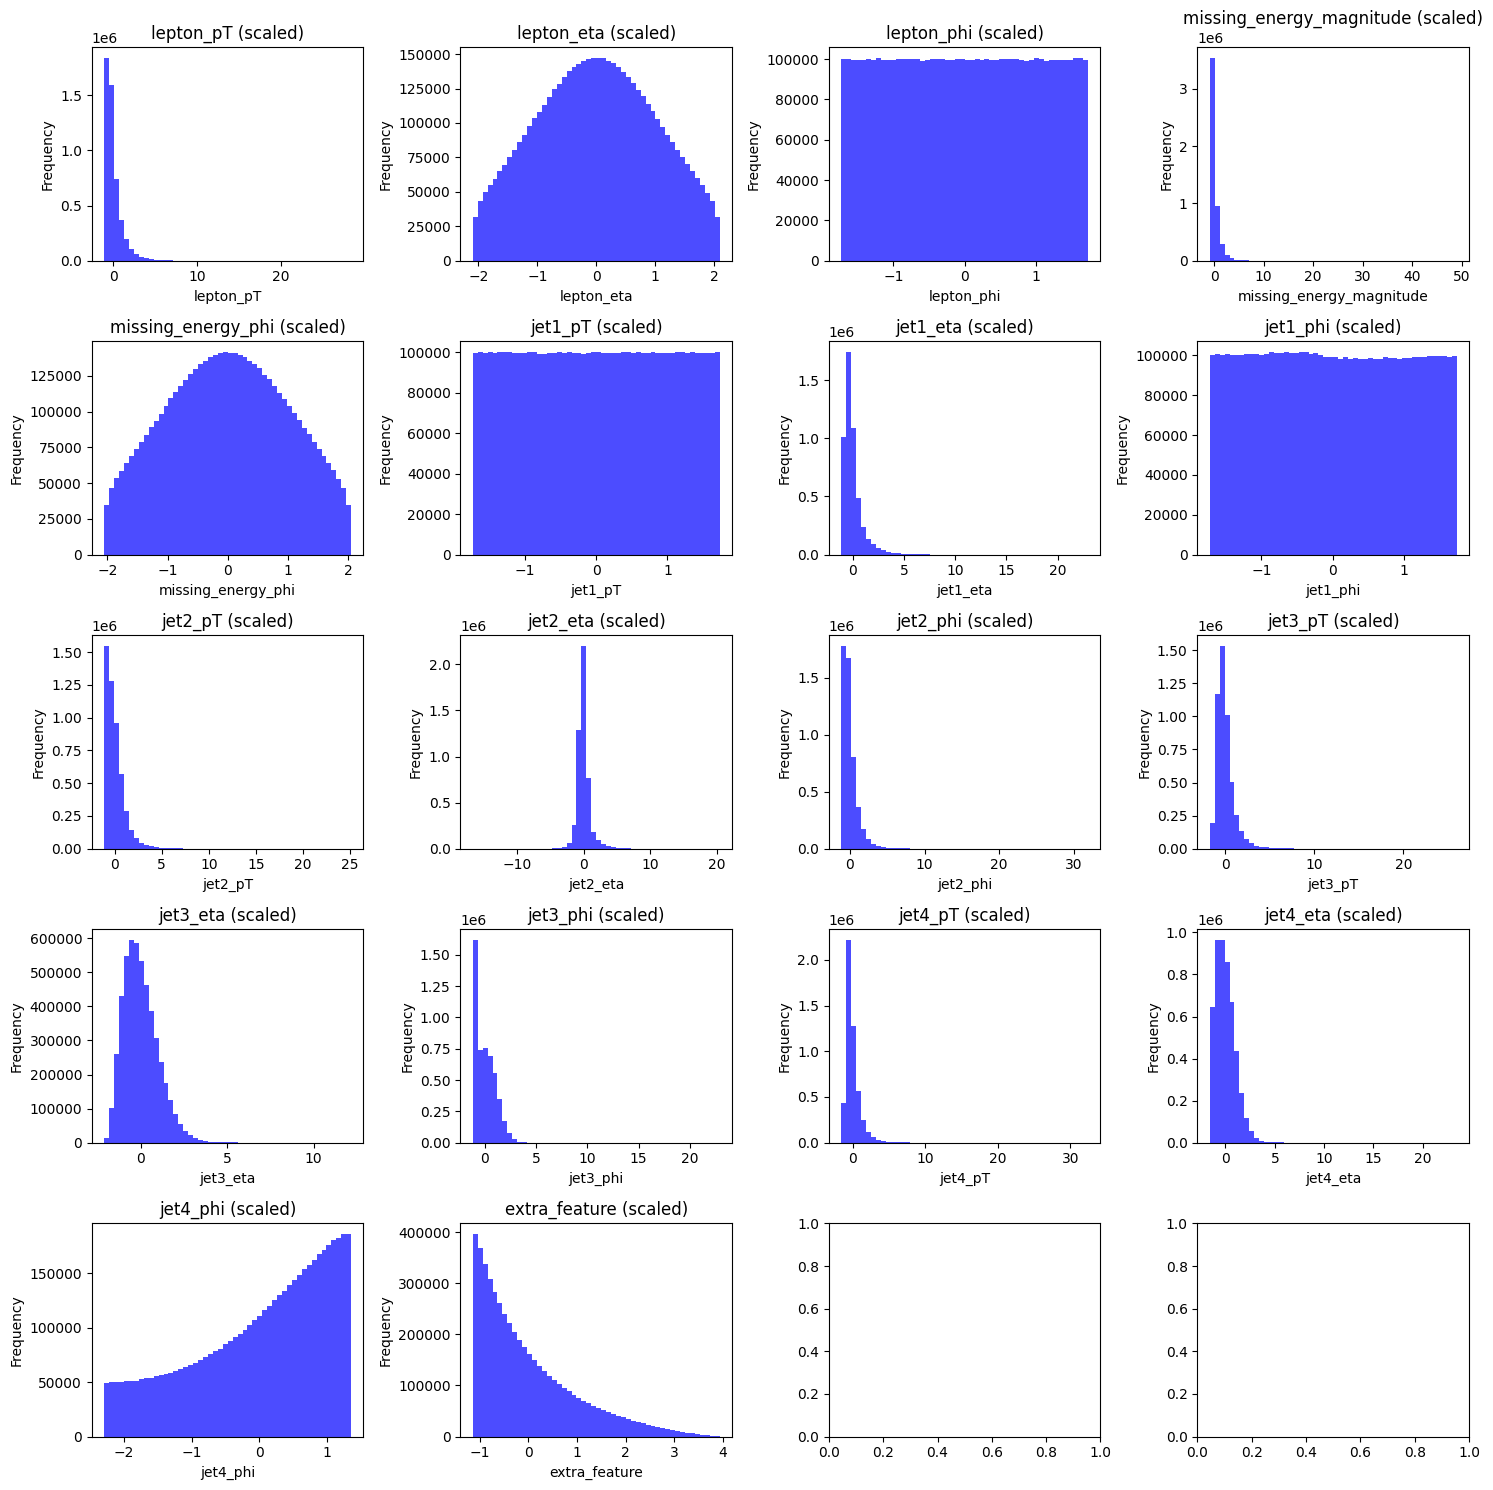

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub

#Downloading the dataset
path = kagglehub.dataset_download("janus137/supersymmetry-dataset")
dataset_path = "/root/.cache/kagglehub/datasets/janus137/supersymmetry-dataset/versions/1/supersymmetry_dataset.csv"

data = pd.read_csv(dataset_path, header = 0)

#Assigning columns, which are defined in the original dataset
data.columns = [
    'label',
    'lepton_pT', 'lepton_eta', 'lepton_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'jet1_pT', 'jet1_eta', 'jet1_phi',
    'jet2_pT', 'jet2_eta', 'jet2_phi',
    'jet3_pT', 'jet3_eta', 'jet3_phi',
    'jet4_pT', 'jet4_eta', 'jet4_phi',
    'extra_feature'
]

print(data.head())
print(data.describe())
print(data.info())

#Defining the features (X) and labels (y)
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state = 42)

#Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train, y_test = y_train.reset_index(drop = True), y_test.reset_index(drop = True)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)

#Visualizing the distributions of all scaled features with axis labels
fig, axs = plt.subplots(5, 4, figsize = (15, 15))
axs = axs.flatten()

for i, col in enumerate(X_train_scaled_df.columns):
    axs[i].hist(X_train_scaled_df[col], bins = 50, color = 'blue', alpha = 0.7)
    axs[i].set_title(f'{col} (scaled)')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Interpretation:**

The dataset contains *5 million* entries, with 19 columns representing various particle features and the corresponding label. Since each graph has been standardized, it represents how frequently each feature occurs in the dataset.

**Information about the key features:**

lepton_pT, lepton_eta, and lepton_phi: Leptons are elementary particles with half-integer spin. pT represents the transverse momentum of the lepton (perpendicular to the beam axis), while eta is its pseudorapidity (describing the angle relative to the beam), and phi refers to the lepton's azimuthal angle.

missing_energy_magnitude and missing_energy_phi: These features correspond to the magnitude and direction of missing transverse energy, which is energy that cannot be accounted for by detected particles in the collision.

jet1_pT, jet2_pT, jet3_pT, jet4_pT: Jets are streams of particles produced when quarks or gluons are scattered. pT measures the transverse momentum, while eta indicates the pseudorapidity.

jet1_eta, jet2_eta, jet3_eta, jet4_eta: Please reference the definitions for jets and eta above.

extra_feature: This column is used for any additional characteristic that differs from the other labels.

The distribution of values for these features reveal key important aspects. For instance, lepton_pT has a broad range of values, with a mean around 1 GeV and a maximum reaching up to 20 GeV. Similarly, jet transverse momenta (e.g., jet1_pT) follow a similar distribution with a mean near 1 GeV, but some entries contain extreme values that likely correspond to high-energy events.

**Binary Classifier:**

The next step is to implement the binary classifier model, which tests three different learning rates (0.005, 0.001, 0.0005) over 15 epochs. The model consists of four fully connected layers with LeakyReLU activation functions in-between, followed by a sigmoid activation function to produce predictions between 0 and 1. The Adam optimizer and binary cross-entropy loss function were used for training. The loss values for both the training and test sets were recorded and plotted to evaluate the model's performance across the different learning rates.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle

#Defining the model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

#Converting the data to tensors
x_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
xy_train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(X_train) / 10), shuffle=True)

#Defining dictionaries to store the losses
train_losses_dict = {}
test_losses_dict = {}

#Defining the training loop for lr = 0.005, 0.001, 0.0005
for lr in [0.005, 0.001, 0.0005]:
    print(f"Learning Rate: {lr}")

    #Initializing the model, loss function, and ADAM optimizer
    input_dim = X_train.shape[1]
    net = BinaryClassifier(input_dim)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net.train()
    train_losses = []
    test_losses = []

    start_time = time.time()

    for epoch in range(15):
        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        net.eval()
        with torch.no_grad():
            y_pred_test = net(x_test_tensor)
            test_loss = loss_fn(y_pred_test, y_test_tensor)
            test_losses.append(test_loss.item())

        end_time = time.time()
        print(f"Epoch {epoch+1:2d} | Time: {end_time - start_time:.1f}s | Train Loss: {loss.item():.1e} | Test Loss: {test_loss.item():.1e}")

    train_losses_dict[lr] = train_losses
    test_losses_dict[lr] = test_losses

#Saving the loss values to a file
with open("loss_data.pkl", "wb") as f:
    pickle.dump({"train": train_losses_dict, "test": test_losses_dict}, f)

print("Loss values saved to loss_data.pkl")
torch.save(net.state_dict(), "binary_classifier.pth")


Learning Rate: 0.005
Epoch  1 | Time: 90.1s | Train Loss: 6.2e-01 | Test Loss: 6.0e-01
Epoch  2 | Time: 181.1s | Train Loss: 4.8e-01 | Test Loss: 4.7e-01
Epoch  3 | Time: 269.0s | Train Loss: 4.6e-01 | Test Loss: 4.6e-01
Epoch  4 | Time: 362.7s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  5 | Time: 453.1s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  6 | Time: 547.4s | Train Loss: 4.5e-01 | Test Loss: 4.4e-01
Epoch  7 | Time: 641.1s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Epoch  8 | Time: 733.4s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Epoch  9 | Time: 824.7s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Epoch 10 | Time: 931.3s | Train Loss: 4.4e-01 | Test Loss: 4.3e-01
Epoch 11 | Time: 1023.3s | Train Loss: 4.4e-01 | Test Loss: 4.3e-01
Epoch 12 | Time: 1113.3s | Train Loss: 4.4e-01 | Test Loss: 4.3e-01
Epoch 13 | Time: 1203.6s | Train Loss: 4.3e-01 | Test Loss: 4.3e-01
Epoch 14 | Time: 1294.2s | Train Loss: 4.3e-01 | Test Loss: 4.3e-01
Epoch 15 | Time: 1388.1s | Train Loss:

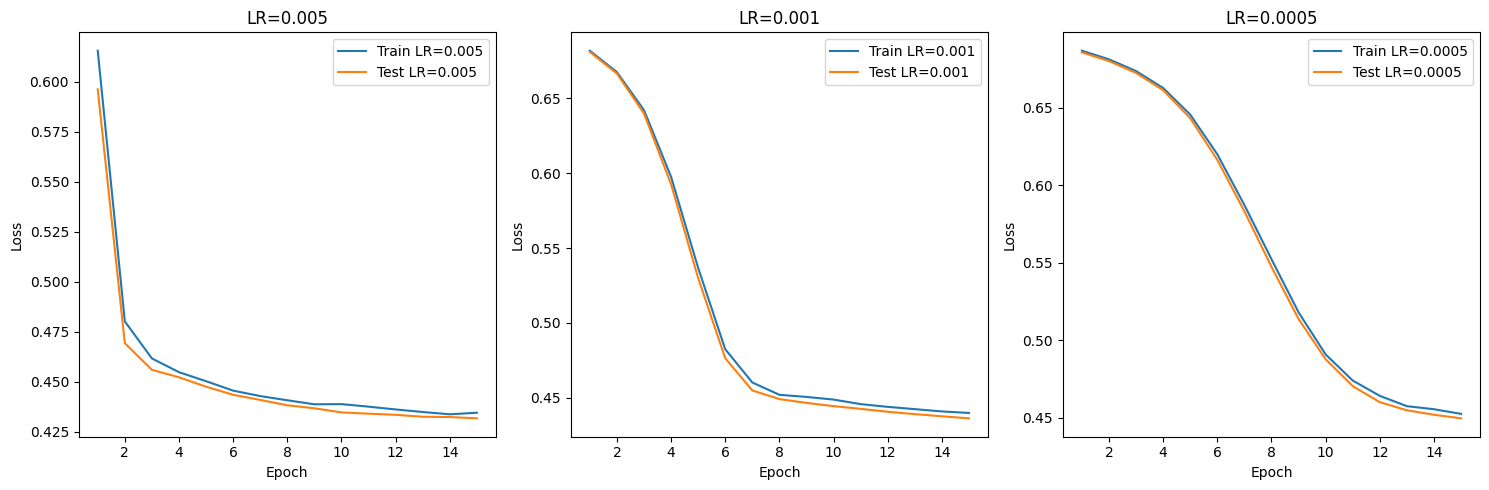

In [3]:
import pickle
import matplotlib.pyplot as plt

#Loading the loss data
with open("loss_data.pkl", "rb") as f:
    loss_data = pickle.load(f)

#Retrieving the learning rates
learning_rates = list(loss_data["train"].keys())

fig, axes = plt.subplots(1, len(learning_rates), figsize=(15, 5))

#Ploting training and test loss for each learning rate
for i, lr in enumerate(learning_rates):
    ax = axes[i]  #Getting the current subplot axes

    #Plotting the training loss
    ax.plot(range(1, len(loss_data["train"][lr]) + 1), loss_data["train"][lr], label=f"Train LR={lr}")

    #Plotting the test loss
    ax.plot(range(1, len(loss_data["test"][lr]) + 1), loss_data["test"][lr], label=f"Test LR={lr}")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"LR={lr}")
    ax.legend()

plt.tight_layout()
plt.show()

**Interpretation:**

The training loss decreases consistently over time for all learning rates, with the learning rate of 0.005 showing the fastest and most stable convergence. By the 10th epoch, the 0.005 learning rate plateaus at a value of around 0.43.

In contrast, the 0.001 and 0.0005 learning rates show slower and less smooth progression. With a learning rate of 0.001, there is noticeable improvement by the fourth epoch, and both the training and test losses converge at approximately 0.44 by the 11th epoch. The 0.0005 learning rate follows a similar trajectory but converges more slowly, reaching a value of 0.45 by the 14th epoch.

Overall, while all learning rates exhibit a downward trend in loss, the 0.005 rate provides the most efficient and stable training process, achieving the lowest loss faster than the other rates.

**ROC Curve:**

The next step is to use a ROC curve to plot the True Positive Rate (TPR) against the False Positive Rate (FPR) to get an understanding of how it is performing compared to a random classifier.

<ipython-input-6-48560d5a6f4e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("binary_classifier.pth"))


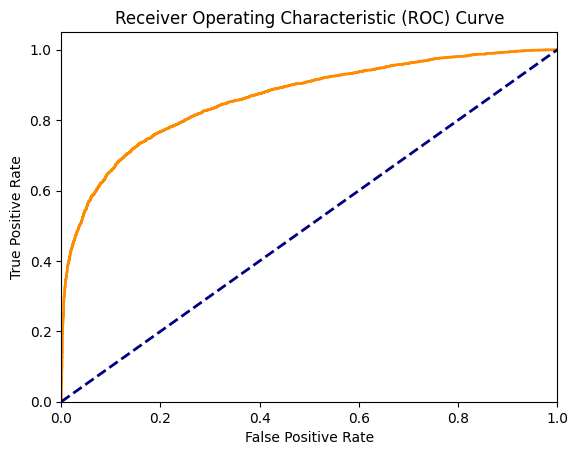

AUC: 0.86


In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

#Loading the trained model
net.load_state_dict(torch.load("binary_classifier.pth"))
net.eval()
with torch.no_grad():
    y_pred_test = net(x_test_tensor)

#Converting the predictions to numpy
y_pred_probabilities = y_pred_test.cpu().numpy().flatten()
y_test_flat = y_test_tensor.cpu().numpy().flatten()

#Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_probabilities)
#Calculating the AUC directly
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

print(f'AUC: {roc_auc:.2f}')

**Interpretation:**

The ROC curve demonstrates a steady rise, indicating that the model is effectively distinguishing between positive and negative instances. The area under the curve (AUC) is 0.86, which means the model is effectively able to separate positive and negative classes.

**Confusion Matrix:**

The following step is to use a confusion matrix to further interpret the breakdown of the model's predictions. The output will represent the counts for True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives
(TP).

<ipython-input-8-a1db965381f1>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("binary_classifier.pth"))


Accuracy: 0.7865
Precision: 0.8632


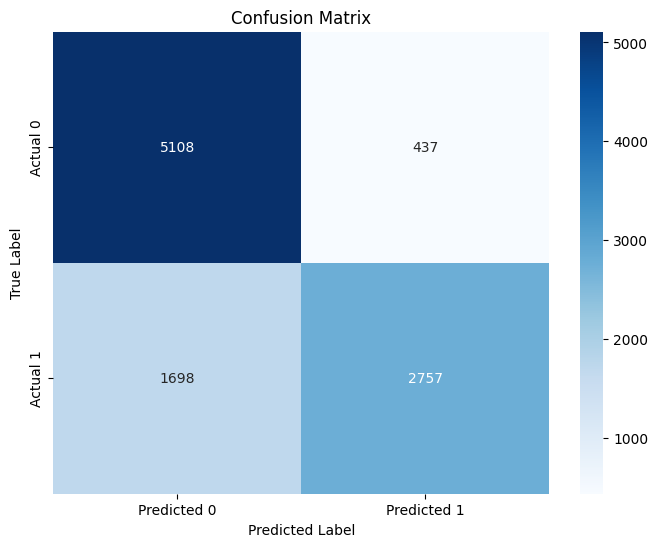

In [8]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Loading the trained model
net.load_state_dict(torch.load("binary_classifier.pth"))
net.eval()
with torch.no_grad():
    y_pred_test = net(x_test_tensor)

y_pred_probs = y_pred_test
y_pred_binary = (y_pred_probs > 0.6).float()

y_test_no = y_test_tensor.cpu().numpy()
y_pred_binary_np = y_pred_binary.cpu().numpy()

cm = confusion_matrix(y_test_no, y_pred_binary_np)

TN, FP, FN, TP = cm.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['Predicted 0', 'Predicted 1'],
            yticklabels = ['Actual 0', 'Actual 1']
            )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Interpretation:**

Let's breakdown each quadrant of the confusion matrix. As a reminder, 1 represents a SUSY particle and 0 represents a SM particle.

True Negatives (TN): 5108 (Predicted 0, Actual 0).

False Positives (FP): 437 (Predicted 1, Actual 0).

False Negatives (FN): 1698 (Predicted 0, Actual 1).

True Positives (TP): 2757 (Predicted 1, Actual 1).

The model has an accuracy of 0.7865, which means the model correctly predicted 78.65% of the test set. $\text{Accuracy: }\frac{TP + TN}{TP + TN + FP + FN}$

The model has a precision of 0.8632, which means 86.32% of the predicted positives were actually positive. $\text{Precision: }\frac{TP}{TP + FP}$

While the model seems to perform well overall, the high number of false negatives suggests that it could be improved further, especially in correctly identifying SUSY particles. Something to note is the adjustion of the treshold value from 0.5 to 0.6, which was determined from the histogram below to classify more true positive SUSY particles.


**Histogram:**

The next step is to visualize the distribution of predicted probabilities for both Standard Model (SM) and Supersymmetric (SUSY) particles based on the trained model’s predictions. These predicted probabilities indicate how likely each event is to belong to the SM class (label = 0) or the SUSY class (label = 1). A well-performing classification model should show that the predicted probabilities for SM events are concentrated near 0, while the probabilities for SUSY events should be concentrated near 1.

<Figure size 800x600 with 0 Axes>

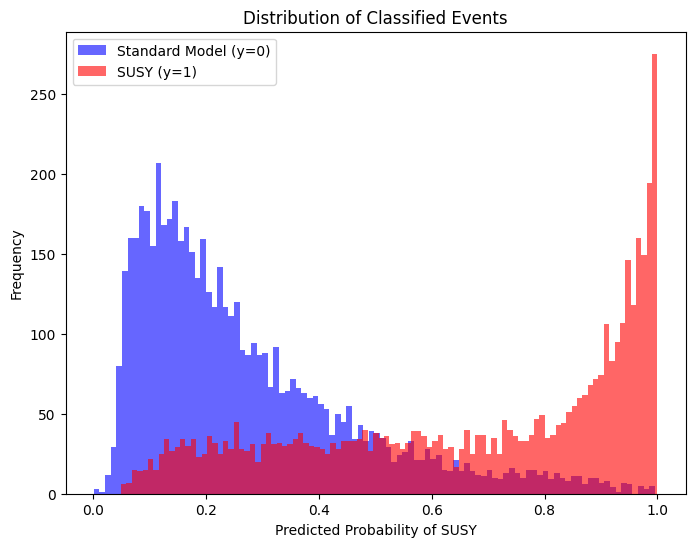

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert tensor predictions to NumPy
y_pred_probs = y_pred_test.cpu().numpy().flatten()
y_true = y_test_tensor.cpu().numpy().flatten()

# Separate predictions based on true labels
susy_probs = y_pred_probs[y_true == 1]  # SUSY events
sm_probs = y_pred_probs[y_true == 0]  # Standard Model events

# Create histogram plots
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
plt.hist(sm_probs, bins=100, color="blue", label="Standard Model (y=0)", alpha=0.6)
plt.hist(susy_probs, bins=100, color="red", label="SUSY (y=1)", alpha=0.6)

plt.xlabel("Predicted Probability of SUSY")
plt.ylabel("Frequency")
plt.title("Distribution of Classified Events")
plt.legend()
plt.show()

**Interpretation:**

The histogram shows a distinct separation between the predicted probabilities for SM events (represented by blue bars) and SUSY events (represented by red bars). However, there is noticeable overlap between the two classes (represented by the pink bars), which suggests that further improvements may be needed.

**Autoencoder for Feature Extraction:**

The final step involves using a Variational Autoencoder (VAE) for feature extraction. The VAE consists of an encoder that maps the input data to a compressed latent space, and a decoder that reconstructs the original data from the lower-dimensional representation. The goal is to minimize the reconstruction error between the original data and the reconstructed data.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

#Defining the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=24):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc21 = nn.Linear(64, latent_dim)
        self.fc22 = nn.Linear(64, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 64)
        self.fc4 = nn.Linear(64, input_dim)
        self.fc5 = nn.Linear(input_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.tanh(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

#Adjusting loss function
def loss_function_MSE(x_hat, x, mu, logvar, β=0.005):
    MSE = nn.functional.mse_loss(x_hat, x, reduction='mean')
    logvar = torch.clamp(logvar, min=-10, max=10)  #Preventing instability in KL term
    KLD = 0.5 * torch.mean(logvar.exp() - logvar - 1 + mu.pow(2))
    return MSE + β * KLD

learning_rate = 5e-4
epochs = 15
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Model setup
input_dim = X_train_scaled_df.shape[1]
model = VAE(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Converting the data to tensors
X_train_tensor = torch.tensor(X_train_scaled_df.values, dtype=torch.float32, device=device)
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_function_MSE(x_hat, x, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  #Gradient clipping!
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch+1}: Average training loss: {train_loss / len(train_loader):.4f}')


Epoch 1: Average training loss: 0.2380
Epoch 2: Average training loss: 0.2269
Epoch 3: Average training loss: 0.2259
Epoch 4: Average training loss: 0.2253
Epoch 5: Average training loss: 0.2247
Epoch 6: Average training loss: 0.2244
Epoch 7: Average training loss: 0.2242
Epoch 8: Average training loss: 0.2241
Epoch 9: Average training loss: 0.2240
Epoch 10: Average training loss: 0.2238
Epoch 11: Average training loss: 0.2238
Epoch 12: Average training loss: 0.2237
Epoch 13: Average training loss: 0.2237
Epoch 14: Average training loss: 0.2236
Epoch 15: Average training loss: 0.2235


Visualizing the results:

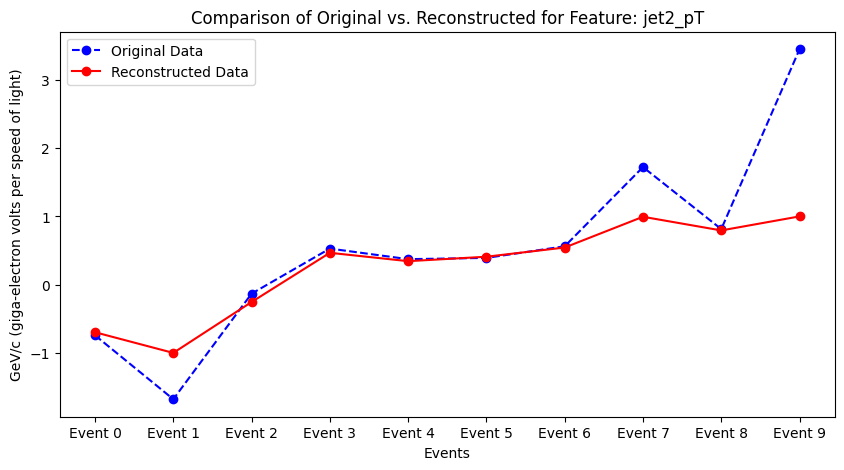

In [14]:
import matplotlib.pyplot as plt
import numpy as np

feature_idx = 9
feature_name = data.columns[9]

#Extracting values for the selected feature across multiple samples
num_samples = 10
original_values = X_train_scaled[:num_samples, feature_idx]
reconstructed_values = model(torch.tensor(X_train_scaled[:num_samples, :], dtype=torch.float32, device=device))[0].cpu().detach().numpy()[:, feature_idx]

#Creating a plot to compare original vs. reconstructed values
x_labels = [f"Event {i}" for i in range(num_samples)]

plt.figure(figsize=(10, 5))

plt.plot(x_labels, original_values, label="Original Data", marker='o', linestyle="--", color='blue')
plt.plot(x_labels, reconstructed_values, label="Reconstructed Data", marker='o', linestyle='-', color='red')

plt.xlabel("Events")
plt.ylabel("GeV/c (giga-electron volts per speed of light)")
plt.title(f"Comparison of Original vs. Reconstructed for Feature: {feature_name}")
plt.xticks()
plt.legend()
plt.show()

**Interpretation:**

The purpose of this graph is to compare the original and reconstructed values for ten selected events from the "jet2_pT" label. As a refresher, this label represents the transverse momentum of a jet, which is a cone of particles produced in high-energy collisions. The graphs shows that it performs for some events, such as the 4th, 5th, and 6th events, but struggled to capture "extreme values" such as in the 1st, 7th, and 9th events. One way to improve the model's performance is to further tweak the latent space dimensionality, network architecture, or hyperparameters to enhance the reconstruction accuracy.

**Conclusion:**

The goal of this project was to classify Supersymmetric (SUSY) particles from Standard Model (SM) particles using a binary classifier with an additional focus on improving feature extraction using a Variational Autoencoder (VAE). The binary classfier had an accuracy of 78.57%, but the high false negative rate suggests that there were limitations in distinguishing subtle differences. The VAE, while effective in compressing the data into a latent space, struggled with reconstruction, showing noticeable deviations between the original and reconstructed values. This suggested that the latent space representation might not be complex enough to capture underlying data patterns. Further improvement to this project include fine-tuning hyperparameters, expanding the latent space, or modifying the model architecture to improve both classification accuracy and feature reconstruction.